# Importing Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,accuracy_score,f1_score,roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import string
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Importing Dataset

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Checking for Null values

In [10]:
df.isnull().sum()

qid                0
question_text      0
target             0
structured_text    0
dtype: int64

In [11]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [12]:
df['target'].value_counts()/df['target'].count()*100

0    93.812982
1     6.187018
Name: target, dtype: float64

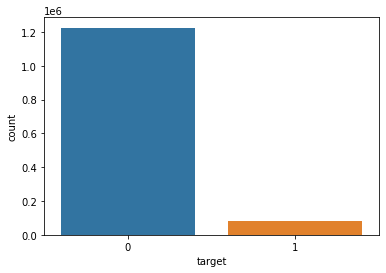

In [13]:
sns.countplot('target', data=df)

Dataset is highly imbalanced

### Data Cleaning

In [5]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
stop_words = stopwords.words('english')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape('''!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'''), ' ', text) #Removing all punctuations.
    text = re.sub(r'[^\x00-\x7F]',' ', text) #Removing all non-ASCII characters.
    text = re.sub('\d+\S',' ', text) #Removing years(1980s, 1970s, etc)
    text = re.sub('\s+', ' ', text) #Removing all extra spaces.
    tokens = nltk.word_tokenize(text) #NLTK Tokenization
    text = [word for word in tokens if word not in stop_words] #Removing stopwords
    text = [lemmatizer.lemmatize(word) for word in text] #Lemmatizing the corpus
    text = ' '.join(text)
    return text

Creating a new columns with clean text

In [8]:
df['structured_text'] = df['question_text'].apply(lambda x : clean_text(x))

In [9]:
df.head()

,qid,question_text,target,structured_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist see province nation
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopted dog would encourage people adopt not shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke used magdeburg hemisphere
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,convert montra helicon mountain bike changing ...


In [14]:
df.shape

(1306122, 4)

### Word Cloud

In [56]:
corpus = []
Sentences = df['question_text'].values
clean_sentences = ""
for i in range(0,10000):
    clean = clean_text(Sentences[i])
    clean_sentences += clean
    required_words = nltk.word_tokenize(clean)
    lemmatizer = WordNetLemmatizer()
    for word in required_words:
        if (word not in set(stopwords.words('english'))):
            corpus.append(word)

In [57]:
word_freq = nltk.FreqDist(corpus)
print(word_freq.most_common(50))

[('get', 512), ('best', 484), ('would', 457), ('people', 433), ('like', 394), ('good', 300), ('one', 256), ('india', 256), ('make', 246), ('year', 239), ('think', 228), ('time', 226), ('way', 213), ('many', 198), ('life', 193), ('someone', 190), ('use', 189), ('much', 179), ('work', 170), ('want', 162), ('country', 158), ('u', 155), ('thing', 152), ('ever', 150), ('find', 145), ('take', 145), ('indian', 143), ('girl', 139), ('know', 136), ('feel', 135), ('go', 133), ('become', 133), ('world', 133), ('without', 133), ('job', 129), ('woman', 127), ('trump', 124), ('better', 124), ('mean', 122), ('person', 120), ('company', 119), ('could', 118), ('book', 117), ('need', 115), ('state', 113), ('day', 113), ('possible', 113), ('student', 112), ('start', 112), ('school', 109)]


(-0.5, 1599.5, 799.5, -0.5)

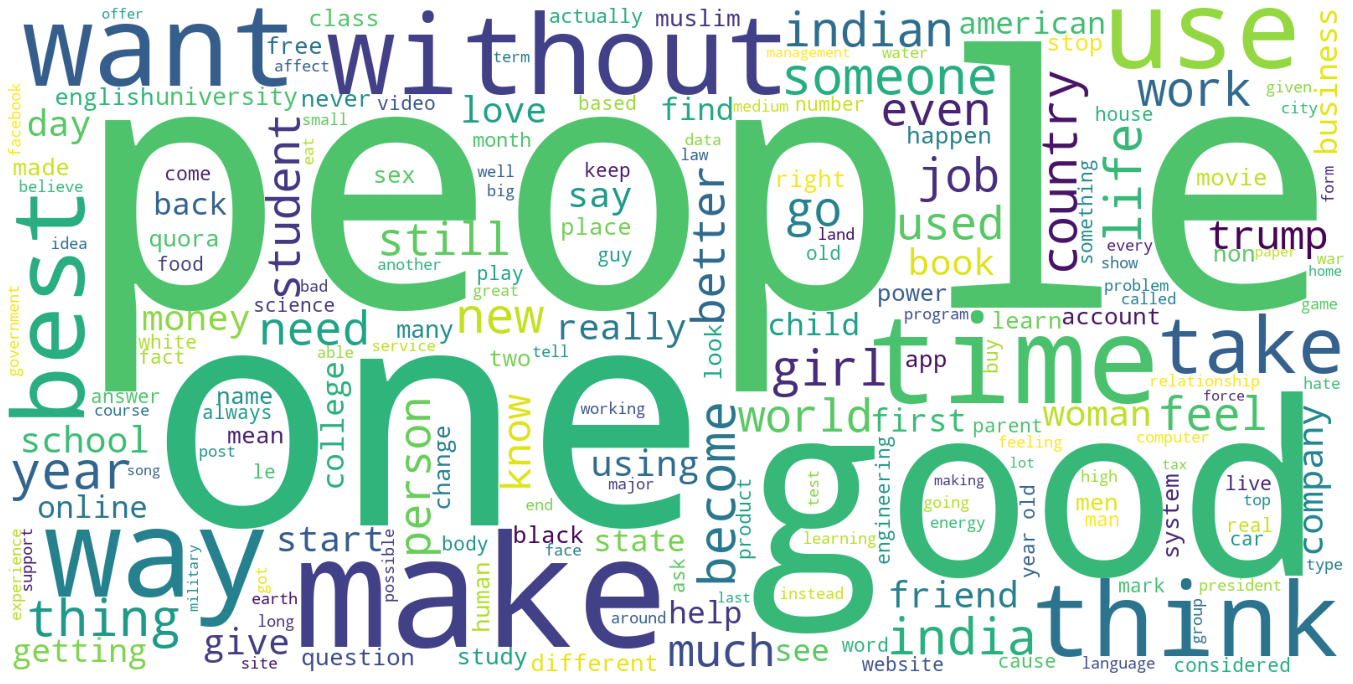

In [125]:
word_cloud = WordCloud(background_color='white', width=1600, height=800).generate(clean_sentences)
plt.figure(figsize=(24,18))
plt.imshow(word_cloud)
plt.axis('off')

## Random Under Sampling

Taking a random sample of the full dataset so that the target variable is balanced.

In [15]:
df = df.sample(frac=1)

In [16]:
df_1 = df.loc[df['target'] == 1]
df_0 = df.loc[df['target'] == 0][:80810]

In [17]:
normal_dist_df = pd.concat([df_0,df_1])

In [18]:
new_df = normal_dist_df.sample(frac=1, random_state=42)

In [19]:
new_df.head()

,qid,question_text,target,structured_text
186209,246c37e6977bc470c42e,"To solve the abortion debate, should men be fo...",1,solve abortion debate men forced chop eggplant
643153,7df69a1728f3c81db280,Why do girls cheat on boys ..and why is?,1,girl cheat boy
925500,b55fbae561034c6ec32e,Why don't Vietnamese Muslims rise up against V...,1,vietnamese muslim rise vietnam join malaysia
710412,8b12469fc0f1513fa21c,What do you think about the cutoff for BA Japa...,0,think cutoff ba japanese seeing jnu entrance e...
639179,7d32271d3e6b0a1e7544,Why do black women prefer to settle down with ...,1,black woman prefer settle white men


In [20]:
print(new_df['target'].value_counts()/len(new_df))

1    0.5
0    0.5
Name: target, dtype: float64


## Vectorication of the features

In [21]:
required_text = new_df['structured_text'].values
word_vectorizer = TfidfVectorizer(sublinear_tf=True,stop_words='english',max_features=2000)
x = word_vectorizer.fit_transform(required_text)

In [22]:
y = new_df.loc[:,'target'].values

In [23]:
print(x.shape)
print(y.shape)

(161620, 2000)
(161620,)


### Splitting the dataset into training and test set

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state=42)

### Function for calculating model performance

In [25]:
def score(y_pred,y_test):
    cm = confusion_matrix(y_test,y_pred)
    print(cm)
    accuracy = accuracy_score(y_test,y_pred)*100
    f1 = f1_score(y_test,y_pred)*100
    auc = roc_auc_score(y_test,y_pred)*100
    print("Accuracy Score", accuracy, "%")
    print("F1 Score", f1, "%")
    print("ROC_AUC Score", auc, "%")
    return (accuracy, auc)

In [26]:
print(x_train.shape)
print(y_train.shape)

(121215, 2000)
(121215,)


# Models

In [80]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [81]:
for key, classifier in classifiers.items():
    classifier.fit(x_train,y_train)
    training_score = cross_val_score(classifier, x_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 86.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 81.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 85.0 % accuracy score


### Logistic Regression

In [82]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train,y_train)
y_log_pred = log_reg.predict(x_test)

In [128]:
log_acc, log_auc = score(y_test,y_log_pred)

[[17567  2953]
 [ 2619 17266]]
Accuracy Score 86.20962752134636 %
F1 Score 86.10612407739877 %
ROC_AUC Score 86.21921504302762 %


### Decision Tree Classifier

In [84]:
dt_classifier = DecisionTreeClassifier(criterion='entropy',random_state=42)
dt_classifier.fit(x_train,y_train)
y_dt_pred = dt_classifier.predict(x_test)

In [129]:
dt_acc, dt_auc = score(y_test,y_dt_pred)

[[16427  3871]
 [ 3759 16348]]
Accuracy Score 81.11619849028585 %
F1 Score 81.0792044834598 %
ROC_AUC Score 81.11708686735642 %


### Random Forrest Classifier

In [86]:
rf_classifer = RandomForestClassifier(criterion='entropy',random_state=42)
rf_classifer.fit(x_train,y_train)
y_rf_pred = rf_classifer.predict(x_test)

In [130]:
rf_acc, rf_auc = score(y_test,y_rf_pred)

[[16760  2655]
 [ 3426 17564]]
Accuracy Score 84.94988244029204 %
F1 Score 85.24351476619185 %
ROC_AUC Score 85.0014741577026 %


## LightGBM

In [45]:
lgb_classifier = lgb.LGBMClassifier(boosting_type='goss')

In [46]:
lgb_classifier.fit(x_train, y_train)

LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
y_pred_lgb = lgb_classifier.predict(x_test)

In [48]:
lgb_acc, lgb_auc = score(y_test,y_pred_lgb)

[[17555  3771]
 [ 2631 16448]]
Accuracy Score 84.15542630862517 %
F1 Score 83.70909461041276 %
ROC_AUC Score 84.26366408406764 %


### XGBoost

In [88]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')

#### Using GridSearch to find the best hyperparameters for XGBoost Classifier

In [89]:
params = {
    'max_depth' : [3, 4, 5],
    'learning_rate' : [0.1, 0.01, 0.05],
    'gamma' : [0, 0.25, 1.0],
    'scale-pos-weight' : [1, 3, 5]
}

In [90]:
grid_search = GridSearchCV(estimator=xgb_classifier,
                          param_grid=params,
                          n_jobs=-1,
                          cv=3,
                          verbose=True)

In [91]:
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 23.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5],
                   

In [92]:
grid_search.best_params_

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'scale-pos-weight': 1}

In [93]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale-pos-weight=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [49]:
classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1,
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1)

In [50]:
classifier.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=8, nthread=None, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=1)

In [51]:
y_xgb_pred = classifier.predict(x_test)

In [52]:
xgb_acc, xgb_auc = score(y_test,y_xgb_pred)

[[18070  6249]
 [ 2116 13970]]
Accuracy Score 79.29711669347853 %
F1 Score 76.95909654317586 %
ROC_AUC Score 80.57487322308572 %


#### Using GridSearch to find the best hyperparameters for Logistic Regression

In [100]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [101]:
grid = GridSearchCV(log_reg,
                   param_grid=log_reg_params,
                   n_jobs = -1,
                   cv=10,
                   verbose=True)

In [102]:
grid.fit(x_train,y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   44.6s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [103]:
grid.best_params_

{'C': 10, 'penalty': 'l2'}

In [104]:
grid.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
log_classifier = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
log_classifier.fit(x_train,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred = log_classifier.predict(x_test)
log_acc, log_auc = score(y_test,y_pred)

[[17466  2834]
 [ 2720 17385]]
Accuracy Score 86.254176463309 %
F1 Score 86.22656482491817 %
ROC_AUC Score 86.25521798733985 %


#### Using GridSearch to find the best hyperparameters for Random Forrest Classifier

In [112]:
rf_params = {
    'n_estimators' : [10, 50, 100, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 3],
    'min_weight_fraction_leaf' : [0, 0.1, 0.5]
}

In [113]:
rf_grid = GridSearchCV(rf_classifer,
                       param_grid = rf_params,
                       cv=3,
                       n_jobs=-1,
                       verbose=True)

In [114]:
rf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  3.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, ra

In [115]:
rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 200}

In [116]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
rf_classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
rf_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
y_pred_rf = rf_classifier.predict(x_test)
rf_acc, rf_auc = score(y_test,y_pred_rf)

[[18008  6674]
 [ 2178 13545]]
Accuracy Score 78.09182031926741 %
F1 Score 75.37143175115463 %
ROC_AUC Score 79.55386679989037 %


## Comparing Model Performance

Since we have performed Random Undersampling and the dataset is perfectly balanced, we will use Accuracy to identify the best model.

In [59]:
model_accuracy = [log_acc, rf_acc, xgb_acc, lgb_acc]
model_auc = [log_auc, rf_auc, xgb_auc, lgb_auc]
models=["Logistic Regression", "Random Forrest", "XGBoost", "LightGBM"]

Text(0.5, 1.0, 'Comparing Model Accuracy(Test Set)')

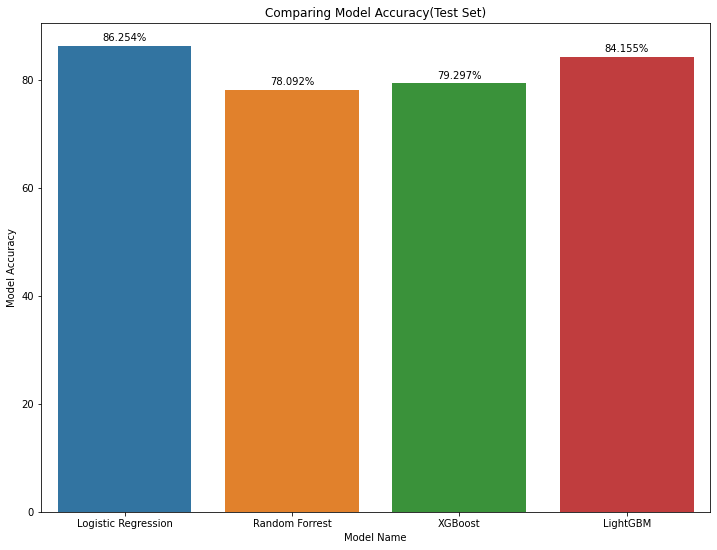

In [60]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_accuracy)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model Accuracy')
plt.xlabel('Model Name')
plt.title('Comparing Model Accuracy(Test Set)')

Text(0.5, 1.0, 'Comparing Model AUC Score(Test Set)')

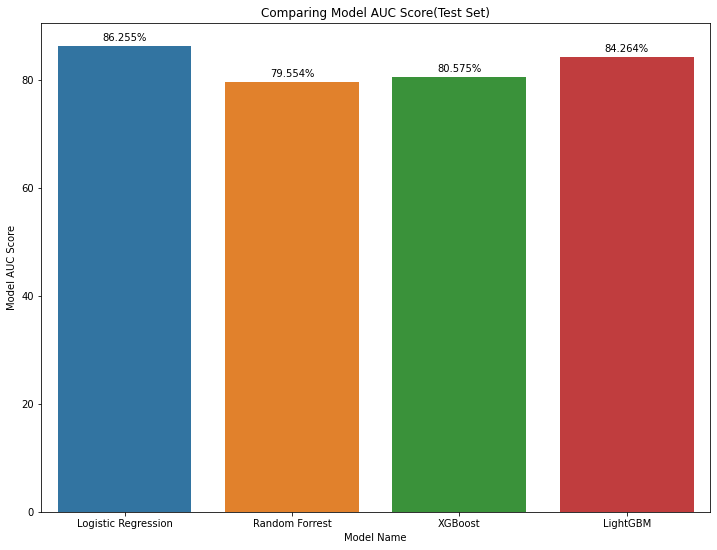

In [61]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_auc)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model AUC Score')
plt.xlabel('Model Name')
plt.title('Comparing Model AUC Score(Test Set)')

As we can see, Logistic Regression outperforms every model for both the metrics.

## Final Cross Validation

In [63]:
log_cv = cross_val_score(log_classifier,x_train, y_train, cv=10, scoring='accuracy')

In [64]:
xgb_cv = cross_val_score(classifier, x_train, y_train, cv=10, scoring='accuracy')

In [65]:
rf_cv = cross_val_score(rf_classifier, x_train, y_train, cv=10, scoring='accuracy')

In [62]:
lgb_cv = cross_val_score(lgb_classifier, x_train, y_train, cv=10, scoring='accuracy')

In [66]:
print("Cross Validation Score for Logistic Regreesion Model is: {:1.3f} +- {:1.3f}".format(log_cv.mean()*100, log_cv.std()*100))
print("Cross Validation Score for Random Forrest Model is: {:1.3f} +- {:1.3f}".format(rf_cv.mean()*100, rf_cv.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv.mean()*100, xgb_cv.std()*100))
print("Cross Validation Score for LightGBM Model is: {:1.3f} +- {:1.3f}".format(lgb_cv.mean()*100, lgb_cv.std()*100))

Cross Validation Score for Logistic Regreesion Model is: 86.421 +- 0.253
Cross Validation Score for Random Forrest Model is: 77.944 +- 0.242
Cross Validation Score for XGBoost Model is: 79.443 +- 0.220
Cross Validation Score for LightGBM Model is: 84.160 +- 0.214


Cross Validation confirms that Logistic Regression was the best performing model.

# Logistic Regression was the best model with an accuracy of 86.5%.